## 3. Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('code/')
from custom_transformers import MissingValuesTransformer, AutoCorrelationFeaturesTransformer

from sklearn.pipeline import Pipeline
from joblib import load

### 3.1 Data collection

In [2]:
# Data from https://www.kaggle.com/selfishgene/historical-hourly-weather-data
SENSOR = 'pressure'
CITY = 'Seattle'
df = pd.read_csv('../data/{}.csv'.format(SENSOR))
df_origin = pd.DataFrame(df[['datetime', CITY]])
df_origin.columns = ['datetime', SENSOR]

### 3.2 Data preparation

In [3]:
preprocess = load('model/{}_{}_data_preparation.joblib'.format(CITY, SENSOR))

In [4]:
df_preprocessed = preprocess.fit_transform(df_origin)

In [5]:
df_preprocessed.head(3)

,datetime,pressure,pressure-h-1,pressure-h-2,pressure-h-3,pressure-h-4,pressure-h-5
5,2012-10-01 18:00:00,1030.0,1029.0,1028.0,1028.0,1027.0,1027.0
6,2012-10-01 19:00:00,1031.0,1030.0,1029.0,1028.0,1028.0,1027.0
7,2012-10-01 20:00:00,1031.0,1031.0,1030.0,1029.0,1028.0,1028.0


In [6]:
unseen_from = str(pd.to_datetime(df_preprocessed['datetime'].max()) - pd.Timedelta('15D'))
df_unseen = df_preprocessed[df_preprocessed['datetime'] >= unseen_from].copy()
df_train_test = df_preprocessed[df_preprocessed['datetime'] < unseen_from].copy()

In [7]:
features = df_train_test[df_train_test.columns.difference(['datetime', SENSOR])].columns.values

### 3.3 Scaling the data

In [8]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.01, 0.99))

scaled_features = min_max_scaler.fit_transform(df_train_test[features])
scaled_target  = min_max_scaler.fit_transform(df_train_test[SENSOR].values.reshape(-1, 1))

# pd.DataFrame(scaled_features, columns=features)

### 3.4 Model

In [9]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
input_layer = Input(shape=(len(features)), dtype='float32')
dense1 = Dense(60, activation='linear')(input_layer)
dense2 = Dense(60, activation='linear')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='linear')(dropout_layer)

In [11]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 60)                360       
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


### 3.5 Spliting the data

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x_train, x_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=.2, shuffle=True)
print(x_train.shape, x_test.shape)

(35908, 5) (8978, 5)


### 3.6 Training and validation

In [14]:
early_stopping = EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)
history = model.fit(x=x_train, y=y_train, batch_size=5, epochs=30, verbose=1, validation_data=(x_test, y_test), shuffle=True, callbacks=[early_stopping])

Epoch 1/30
7182/7182 [==============================] - 4s 491us/step - loss: 0.0047 - val_loss: 0.0015
Epoch 2/30
7182/7182 [==============================] - 3s 475us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 3/30
7182/7182 [==============================] - 3s 475us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/30
7182/7182 [==============================] - 3s 468us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/30
7182/7182 [==============================] - 3s 473us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 6/30
7182/7182 [==============================] - 3s 475us/step - loss: 0.0017 - val_loss: 0.0014


Minimum Validation Loss: 0.0014


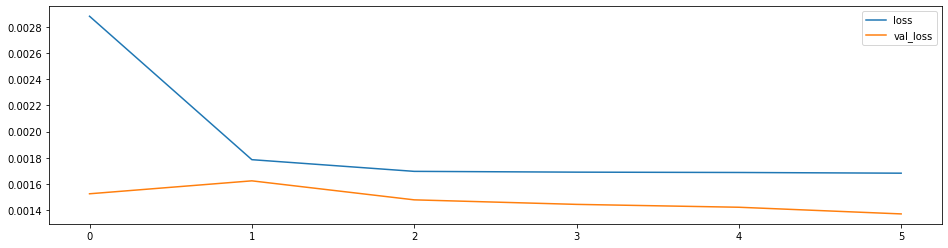

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(figsize=(16,4))
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

### 3.7 Predictions

In [16]:
from sklearn import preprocessing
features_scaler = preprocessing.MinMaxScaler(feature_range=(0.01, 0.99))
target_scaler = preprocessing.MinMaxScaler(feature_range=(0.01, 0.99))

features = df_unseen[df_unseen.columns.difference(['datetime', SENSOR])].columns.values
scaled_features = features_scaler.fit_transform(df_unseen[features])
scaled_target = target_scaler.fit(df_unseen[SENSOR].values.reshape(-1, 1))

In [17]:
y_pred = model.predict(scaled_features)
y_pred_rescaled = target_scaler.inverse_transform(y_pred)

In [18]:
from sklearn.metrics import r2_score
score = r2_score(df_unseen[SENSOR].values, y_pred_rescaled)
print('More the r2 score closer to one, better the predictions of the model')
print('R-squared score for the test set:', round(score,4))

More the r2 score closer to one, better the predictions of the model
R-squared score for the test set: 0.9614


In [19]:
df_final = df_unseen[['datetime', SENSOR]]
df_final['prediction'] = y_pred_rescaled

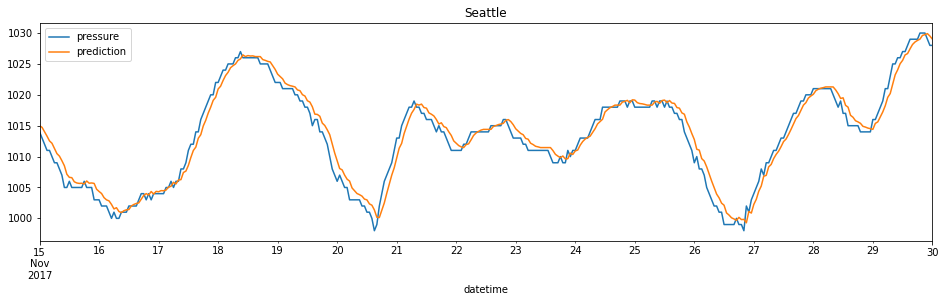

In [20]:
df_final.set_index('datetime').plot(title=CITY, figsize=(16,4))
plt.show()

### 3.8 Save the model